Assignment 1
Daniel Brandenburg n8867887

In [2]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import ML libraries
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import VotingClassifier

# Set a random state value
rs = 10

#import libraries to visualize decision trees
import pydot
from io import StringIO


# Ignore Warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

In [3]:
def PreProcessing (data):
    print("Pre-Processing Step")
    
    # Check if there are any missing target variables
    if data['IsBadBuy'].isna().any():
        print("Missing Target Variables")
    else:
        print("No missing Target Variables")
    
    
    # Handle Bad Columns drop Columns
    data.drop(['PRIMEUNIT', 'AUCGUART', 'WheelTypeID', 'ForSale', 'PurchaseDate'], 
              axis=1, 
              inplace=True)
    

    # Handle Missing Values
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Hyundai':
            data['TopThreeAmericanName'][i] = 'HYUNDAI'
        i += 1
        
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Jeep':
            data['TopThreeAmericanName'][i] = 'JEEP'
        i += 1
        
        
    """ DOES THIS HAVE TO BE THERE """
    # print(data.groupby(['TopThreeAmericanName'])['Make'].value_counts())
    """ DOES THIS HAVE TO BE THERE """
    
    

    # Standardise the capitilization across all object rows
    obj_cols = data.select_dtypes(include='object').columns # Create a list of col names
    for i in obj_cols:              # Interate over the obj_cols list
        data[i] = data[i].str.upper()   # Convert all strings to uppercase  
    # Standardize USA to AMERICA
    data['Nationality'].replace({'USA' : 'AMERICAN'}, inplace = True)
    
    # Turn Transmission into a binary variable with Auto = 1 and Manual = 0
    data.rename({'Transmission' : 'Auto'}, axis = 1, inplace = True)
    # Replace binary columns with 1s and 0s
    data['Auto'].replace({'MANUAL' : 0, 'AUTO' : 1}, inplace=True)
    
    # Remove NOT AVAIL in color and place it in the NaN section
    data['Color'].replace({'NOT AVAIL': np.nan}, inplace = True)
    
    
    """ I'll have to check with teach if this is correct
    #This is the significance test for VNST
    # Check to see if VNST is a statisically significant variable
    # Create a distribution of IsBuyBad for VNST
    VNST_badBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[0]
    VNST_goodBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[1]
    categoricalPlot('VNST')
    
    # Use a Chi2 test to test if there is any corrilation between them, if there is
    # (p < 0.05) discarde the variable
    fScore, pValue = stats.f_oneway(VNST_badBuy, VNST_goodBuy)
    print("The pValaue is " + str(pValue) + " which is significant enough to reject null hypothesis")
    """
    print("Drop VNST due to statistical insignificance")
    data.drop('VNST', axis=1, inplace = True)
    
    # Seperate the Size feature into Size and Body
    tempSize = data['Size'].str.split(' ', expand = True) # Create temp var with split column
    data['Size'] = tempSize[0] # Save the temp var back into data
    data['Body'] = tempSize[1] # Save the temp var back into data
    data['Body'].fillna('CITY', inplace = True) # Assume any other cars are 'City'
    
    
    data.loc[data.Size == 'VAN', 'Body'] = 'Van' # Convert Van into a body type
    data.loc[data.Size == 'VAN', 'Body'] =  np.nan # Take van away from size, shouldn't matter once OH is done
    

    # Replace all non 0, 1 values in IsOnlineSale to 1
    maskOnlineSale = data['IsOnlineSale'] != 0 # Any value that isn't 0 will be set to 1
    data.loc[maskOnlineSale, 'IsOnlineSale'] = 1 # Set the values to 1
    
    
    # Converting the TimeStamp into Quater
    Quarter = [] # Create empty string
    for i, _ in enumerate(data.PurchaseTimestamp): # Loop over the entire dataset
        # Convert the epoch datetime into the quater and append to list
        Quarter.append(pd.Timestamp(data.PurchaseTimestamp.loc[i], unit = 's').quarter)        
    data['Quarter'] = Quarter # Create the column with list
    data.drop('PurchaseTimestamp', axis=1, inplace = True) # Drop old TimeStamp
    
    """ This will take care of any Null values we don't specifically take care of
    by replaceing the missing data with data from the same distibution"""
    conv = []
    for i in data.columns: # Loop over dataset
        if data[i].isna().any() == True: # Check to see if there is a NaN is the feature
            dist = data[i].value_counts(normalize=True) # Find the distrabution of the column
            missing = data[i].isna() # Find where the NaN are
            # Replace the NaNs with values from the same distrabution of the column
            data.loc[missing, i] = np.random.choice(dist.index, size=len(data[missing]),p=dist.values)       
            conv.append(i)
    print("Converted all of " , conv, "s missing values into the same distrubution")
    
    """ This should be the last thing done """
    # Convert all categorical variables into one hot representations
    
    print("The number of features before one hot encoding is " + str(data.shape[1]))
    data_OH = pd.get_dummies(data, columns = ['Auction', 'Make', 'Color', 'VehYear', 
                                              'Nationality', 'Size', 'Body', 'TopThreeAmericanName', 
                                              'WheelType', 'Quarter'])
    print("The number of features after one hot encoding is " + str(data_OH.shape[1]))
    
    return data, data_OH

# Task 1
## Q1
The proportion of cars that are kick is 12.949...%
Detailed below
## Q2
Yes. Details below
Treat '?' and '#VALUE' as NaN
PRIMEUNIT and AUCGUART were dropped due to only having a small amount of data
WheelTypeID and PurchaseDate were duplicates of other features and were dropped
ForSale was dropped because of the data skew
In TopThreeAmericanName Hyundai and Jeep were renamed into HYUNDAI and JEEP
All other cols had thwere strings converted to uppercase
In nationality USA was replaced to AMERICA
Transmission was renamed to Auto and Auto was set to 1, Manual set to 0
In Color, NOT AVIL was changed to NaN
Dropped VNST due to statisical insignificance
Size was split inot Size and Body and Van was placed into the Body feature
Any non-zero values in IsOnlineSale was set to 1
Changed PurchaseTimestamp into days of week
Replace any missing values not specifically taken care of previously to a value choosen randomly from the distibution of the column
## Q3

## Q4

## Q5
Used a train test split with a 20% test set. Using CV allows us to have a smaller test set

In [4]:
def categoricalPlot(cat, cat2 = 'IsBadBuy'): # Cat is the carigorical as a string i.e 'Size'
    pd.crosstab(data[cat],data[cat2]).plot(kind="bar")

In [5]:
def analyse_feature_importance(dm_model, feature_names, n_to_display=5):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

In [6]:
data_raw = pd.read_csv("Kick.csv", # Read the csv into a DF
                   index_col = 'PurchaseID', 
                   na_values = ('?',  '#VALUE!'))

In [7]:
data, data_OH = PreProcessing(data_raw) # PreProcess the data

Pre-Processing Step
No missing Target Variables
Drop VNST due to statistical insignificance
Converted all of  ['Auction', 'VehYear', 'Make', 'Color', 'Auto', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost', 'WarrantyCost', 'Body'] s missing values into the same distrubution
The number of features before one hot encoding is 25
The number of features after one hot encoding is 99


In [31]:
counts = data["IsBadBuy"].value_counts()
total = data["IsBadBuy"].count()
    
# calculate the percentage
# kick is where IsBadBuy == 1
kickPersentage = counts[1] / total * 100
print ("Questin 1.1 :")
print( kickPersentage, "%")

Questin 1.1 :
12.94965763333012 %


In [10]:
# target/input split
y = data_OH['IsBadBuy']
X = data_OH.drop(['IsBadBuy'], axis=1)

In [11]:
X_mat = X.values # Canvert X into a matrix
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

# Decision Tree

In [14]:
modelDT = DecisionTreeClassifier(random_state=rs) # Define the model
modelDT.fit(X_train, y_train) # Fit with data

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [35]:
print("Train accuracy:", modelDT.score(X_train, y_train))
print("Test accuracy:", modelDT.score(X_test, y_test))

Train accuracy: 1.0
Test accuracy: 0.7850771456123433


In [36]:
y_predDT = modelDT.predict(X_test) # Predict the data
print(classification_report(y_test, y_predDT)) # Print the scores

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      7222
           1       0.21      0.24      0.22      1074

   micro avg       0.79      0.79      0.79      8296
   macro avg       0.55      0.55      0.55      8296
weighted avg       0.80      0.79      0.79      8296



In [13]:
# grab feature importances from the model and feature name from the original X
feature_names = X.columns

analyse_feature_importance(modelDT, feature_names, n_to_display=5)

In [39]:
# Define a function to find the root node
def getTreeInfo(model, feature_names):
    features  = [feature_names[i] for i in model.tree_.feature]
    print("Root feature is ", features[0])
    print("Competing featues are ", features[1], 'and ', features[2])
    print("Number of nodes is ", model.tree_.node_count)

In [40]:
getTreeInfo(modelDT, feature_names) # Call the root function

Root feature is  MMRCurrentAuctionAveragePrice
Competing featues are  VehBCost and  VehOdo
Number of nodes is  8277


In [41]:
# Create a graph of the tree
def DTreeGraph(model, colNames):
    dotfile = StringIO()
    export_graphviz(model, out_file=dotfile, feature_names=colNames)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png('grpah.png') # saved in the following file

In [54]:
""" This is take a while
DTreeGraph(modelDT, feature_names)
"""

' This is take a while\nDTreeGraph(model, colNames)\n'

In [63]:
#retrain with a larger minimum number of samples required to split an internal node
test_scoreDT = []
train_scoreDT = []

range_ = range(2, 11)

# check the model performance for max depth from 2-20
for min_samples_split in range_:
    modelDT = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=rs)
    modelDT.fit(X_train, y_train)
    
    test_scoreDT.append(modelDT.score(X_test, y_test))
    train_scoreDT.append(modelDT.score(X_train, y_train))

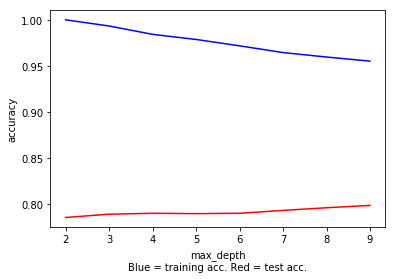

In [64]:
plt.plot(range_, train_scoreDT, 'b', range_, test_scoreDT, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.show()

In [46]:
analyse_feature_importance(modelDT, feature_names, n_to_display=5)

Top five import features
VehOdo : 0.09873405027242388
VehBCost : 0.09247868329992437
MMRCurrentAuctionAveragePrice : 0.08625484742288812
MMRCurrentRetailRatio : 0.06948197568162545
MMRCurrentRetailCleanPrice : 0.05712671346405484


In [18]:
DT_features = ['VehOdo', 'VehBCost', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailRatio', 'MMRCurrentRetailCleanPrice']

In [65]:
getTreeInfo(modelDT, feature_names) # Call the root function

Root feature is  MMRCurrentAuctionAveragePrice
Competing featues are  VehBCost and  VehOdo
Number of nodes is  5861


# Task 2.1

## Q 1.a

## Q 1.b

## Q 1.c

## Q 1.d

## Q 1.e

## Q 1.f

## Q 1.g

In [151]:
# Perform a grid search over the best hyperparameters
params = {'criterion': ['gini', 'entropy'], # What criterion to check
          'max_depth': range(2, 7), # Check the depth, use the graph generated above
          'min_samples_leaf': range(5, 26, 5)} # Define the min sample leafs

cvDT = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10) # Define the model
cvDT.fit(X_train, y_train) # Fit the data to the model
y_predDT = cvDT.predict(X_test) # test the best model

print("Using grid search the accuracy is")
print("Train accuracy:", cvDT.score(X_train, y_train))
print("Test accuracy:", cvDT.score(X_test, y_test))
print(classification_report(y_test, y_predDT))

# print parameters of the best model
print(cvDT.best_params_)

Train accuracy: 0.8704942736588306
Test accuracy: 0.8705400192864031
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.00      0.00      0.00      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.44      0.50      0.47      8296
weighted avg       0.76      0.87      0.81      8296

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20}


In [152]:
# Use these parameters to refine the model
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, cv.best_params_['max_depth']+2),
          'min_samples_leaf': range(cv.best_params_['min_samples_leaf']-4, 
                                    cv.best_params_['min_samples_leaf']+5)}

cvDT = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(criterion= cv.best_params_['criterion'], random_state=rs), cv=10)
cvDT.fit(X_train, y_train)

print("Using the refinded parameters")
print("Train accuracy:", cvDT.score(X_train, y_train))
print("Test accuracy:", cvDT.score(X_test, y_test))

# test the best model
y_predDT = cvDT.predict(X_test)
print(classification_report(y_test, y_predDT))

# print parameters of the best model
print(cvDT.best_params_)

Train accuracy: 0.8704942736588306
Test accuracy: 0.8705400192864031
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.00      0.00      0.00      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.44      0.50      0.47      8296
weighted avg       0.76      0.87      0.81      8296

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 25}


# Task 2.2

## Q 2.a

## Q 2.b

## Q 2.c

## Q 2.d

## Q 2.e

## Q 2.f

## Q 2.g

# Task 2.3

# Task 2.4

# Regression

In [8]:
# Standardize the data
scaler = StandardScaler() # Use the standard scaler
print("The statisics of the data before scaling")
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

The statisics of the data before scaling
Before scaling
-------------
Variable #0: min 0.0, max 1.0, mean 0.96 and std dev 0.19
Variable #1: min 577.0, max 480444.0, mean 71313.66 and std dev 14742.50
Variable #2: min 0.0, max 33543.0, mean 6130.60 and std dev 2483.45
Variable #3: min 0.0, max 36701.0, mean 7370.94 and std dev 2747.10
Variable #4: min 0.0, max 36726.0, mean 8436.79 and std dev 3168.31


In [9]:
X_train = scaler.fit_transform(X_train, y_train) # Scale the data
X_test = scaler.transform(X_test) # and the training data
print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

After scaling
-------------
Variable #0: min -5.166832711353661, max 0.19354216710029656, mean -0.00 and std dev 1.00
Variable #1: min -4.798147121933455, max 27.751769239167356, mean -0.00 and std dev 1.00
Variable #2: min -2.4685779676747215, max 11.038015010356702, mean -0.00 and std dev 1.00
Variable #3: min -2.6831749983459834, max 10.67674717671357, mean -0.00 and std dev 1.00
Variable #4: min -2.6628639607402174, max 8.928788847328969, mean -0.00 and std dev 1.00


In [22]:
modelLG = LogisticRegression(random_state=rs) # Define the model
modelLG.fit(X_train, y_train) # fit it to training data
y_predLG = modelLG.predict(X_test)

In [11]:
# training and test accuracy
print("Train accuracy:", modelLG.score(X_train, y_train))
print("Test accuracy:", modelLG.score(X_test, y_test))
# classification report on test data
print(classification_report(y_test, y_predLG))

Train accuracy: 0.8704339963833635
Test accuracy: 0.8699373191899711
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.22      0.00      0.00      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.55      0.50      0.47      8296
weighted avg       0.79      0.87      0.81      8296



In [25]:
coefLG = modelLG.coef_[0]

# limit to 20 features, you can comment the following line to print out everything
coefLG = coefLG[:5]

for i in range(len(coefLG)):
    print(feature_names[i], ':', coefLG[i])

Auto : 0.0907158568715187
VehOdo : 0.07846808772491289
MMRAcquisitionAuctionAveragePrice : -0.3824806818712443
MMRAcquisitionAuctionCleanPrice : -0.17866004559488827
MMRAcquisitionRetailAveragePrice : 0.660225483814743


In [17]:
# Use GCV to find the optimal parameters
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cvLG = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvLG.fit(X_train, y_train)

# test the best model
print("Train accuracy:", cvLG.score(X_train, y_train))
print("Test accuracy:", cvLG.score(X_test, y_test))

y_predLG = cvLG.predict(X_test)
print(classification_report(y_test, y_predLG))

# print parameters of the best model
print(cvLG.best_params_)

Train accuracy: 0.8704038577456299
Test accuracy: 0.8698167791706847
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.12      0.00      0.00      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.50      0.50      0.47      8296
weighted avg       0.77      0.87      0.81      8296

{'C': 0.01}


In [20]:
# Use the best paramaters from previous CV to get closer to optimum values
# grid search CV
params = {'C': [pow(10, x) for x in range(-4, -2)]}

# use all cores to tune logistic regression with C parameter
cvLG = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvLG.fit(X_train, y_train)

# test the best model
print("Train accuracy:", cvLG.score(X_train, y_train))
print("Test accuracy:", cvLG.score(X_test, y_test))

y_predLG = cvLG.predict(X_test)
print(classification_report(y_test, y_predLG))

# print parameters of the best model
print(cvLG.best_params_)

Train accuracy: 0.8704038577456299
Test accuracy: 0.8699373191899711
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.14      0.00      0.00      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.51      0.50      0.47      8296
weighted avg       0.78      0.87      0.81      8296

{'C': 0.001}


# Task 3.1

# Task 3.2

# Task 3.3

## Q3.h

## Q3.i

## Q3.j

## Q3.k

## Q3.l

## Q3.m

## Q3.n

In [14]:
# Recursive feature elimination
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10) # fit the model
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 98
Number of features after elimination 6


In [15]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [29]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cvRFE = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvRFE.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", cvRFE.score(X_train_sel, y_train))
print("Test accuracy:", cvRFE.score(X_test_sel, y_test))

y_predRFE = cvRFE.predict(X_test_sel)
print(classification_report(y_test, y_predRFE))

# print parameters of the best model
print(cvRFE.best_params_)

Train accuracy: 0.8705846895720314
Test accuracy: 0.8705400192864031
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.00      0.00      0.00      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.44      0.50      0.47      8296
weighted avg       0.76      0.87      0.81      8296

{'C': 0.01}


# Task 3.4 

## Q4.a

## Q4.b

## Q4.c

## Q4.d

## Q4.e

## Q4.f

# Neural Networks

In [33]:
modelMLP = MLPClassifier(random_state=rs) # Define the model
modelMLP.fit(X_train, y_train) # Fit it

print("Train accuracy:", modelMLP.score(X_train, y_train))
print("Test accuracy:", modelMLP.score(X_test, y_test))

y_predMLP = modelMLP.predict(X_test)
print(classification_report(y_test, y_predMLP))

print(modelMLP)

Train accuracy: 0.9175708257986739
Test accuracy: 0.8326904532304725
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7222
           1       0.26      0.16      0.20      1074

   micro avg       0.83      0.83      0.83      8296
   macro avg       0.57      0.55      0.55      8296
weighted avg       0.80      0.83      0.82      8296

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [32]:
# Use GCV and change the no. of hidden nodes
params = {'hidden_layer_sizes': [(x,) for x in range(5, 20)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.8712176009644365
Test accuracy: 0.8704194792671167
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.48      0.01      0.02      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.68      0.50      0.48      8296
weighted avg       0.82      0.87      0.81      8296

{'alpha': 1e-05, 'hidden_layer_sizes': (5,)}


In [16]:
# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.0001, 0.00001, 0.0000001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train)

print("Train accuracy:", cv.score(X_train_sel, y_train))
print("Test accuracy:", cv.score(X_test_sel, y_test))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.8701928872814949
Test accuracy: 0.8705400192864031
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7222
           1       0.50      0.00      0.00      1074

   micro avg       0.87      0.87      0.87      8296
   macro avg       0.69      0.50      0.47      8296
weighted avg       0.82      0.87      0.81      8296

{'alpha': 0.0001, 'hidden_layer_sizes': (3,)}


In [20]:
"""
Change some of these numbers
"""

# MLP with decision tree features
modelMLP = MLPClassifier(hidden_layer_sizes = [(3,), (3,), (3,), (3,)], alpha = 0.0001, random_state=rs) # Define the model
modelMLP.fit(X_train, y_train) # Fit it

print("Train accuracy:", modelMLP.score(X_train[DT_features], y_train))
print("Test accuracy:", modelMLP.score(X_test[DT_features], y_test))

y_predMLP = modelMLP.predict(X_test[DT_features])
print(classification_report(y_test, y_predMLP))

print(modelMLP)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
"""
Change some of these numbers
"""

# MLP with rfe features
modelMLP = MLPClassifier(hidden_layer_sizes = [(3,), (3,), (3,), (3,)], alpha = 0.0001, random_state=rs) # Define the model
modelMLP.fit(X_train_sel, y_train) # Fit it

print("Train accuracy:", modelMLP.score(X_train_sel, y_train))
print("Test accuracy:", modelMLP.score(X_test_sel, y_test))

y_predMLP = modelMLP.predict(X_test_sel)
print(classification_report(y_test, y_predMLP))

print(modelMLP)

In [ ]:
# Compare the models

# ROC AUC
y_pred_proba_dt = modelDT.predict_proba(X_test)
y_pred_proba_log_reg = modelLR.predict_proba(X_test)
y_pred_proba_nn = modelMLP.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

In [ ]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

In [ ]:
plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Task 4
## Q1.a

## Q1.b

## Q1.c

## Q1.d

## Q1.e

## Q2.a

## Q2.b

## Q2.c

## Q2.d

## Q2.e

## Q3.a

## Q3.b

## Q3.c

## Q3.d

## Q3.e

## Q4

# Ensemble Model


In [ ]:
# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', modelDT), ('lr', modelLR), ('nn', modelMLP)], voting='soft')

In [ ]:
# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])
print("ROC score of voting classifier:", roc_index_ensemble)

# Task 5

## Q1.a

## Q2.a

## Q2.b

# Task 6

## Q1

## Q2

## Q3